In [1]:
!pwd

/home/elicer/Depth-Anything-V2


In [6]:
import numpy as np
from torchvision.transforms import Compose
from depth_anything_v2.util.transform import Resize, NormalizeImage, PrepareForNet

def preprocess_image(raw_img, input_size=518):
    transform = Compose([
        Resize(
            width=input_size,
            height=input_size,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method='lower_bound',
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ])

    image = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB) / 255.0  # HWC, float32
    h, w = raw_img.shape[:2]

    image = transform({'image': image})['image']  # CHW, float32
    image = torch.from_numpy(image).unsqueeze(0)  # [1, 3, H, W]
    
    return image, (h, w)

In [8]:
raw_img = cv2.imread('/home/elicer/datasets/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg')

image_tensor, (h, w) = preprocess_image(raw_img)
image_tensor = image_tensor.to(DEVICE)

with torch.no_grad():
    depth = model.forward(image_tensor)
    depth_resized = torch.nn.functional.interpolate(depth, size=(h, w), mode='bilinear', align_corners=True)
    depth_np = depth_resized[0, 0].cpu().numpy()

In [5]:
import cv2
import torch

from depth_anything_v2.dpt import DepthAnythingV2

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vits' # or 'vits', 'vitb', 'vitg'

model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu'))
model = model.to(DEVICE).eval()

raw_img = cv2.imread('/home/elicer/datasets/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg')
depth = model(raw_img) # HxW raw depth map in numpy

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [1, 518, 616] and output size of (529, 622). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

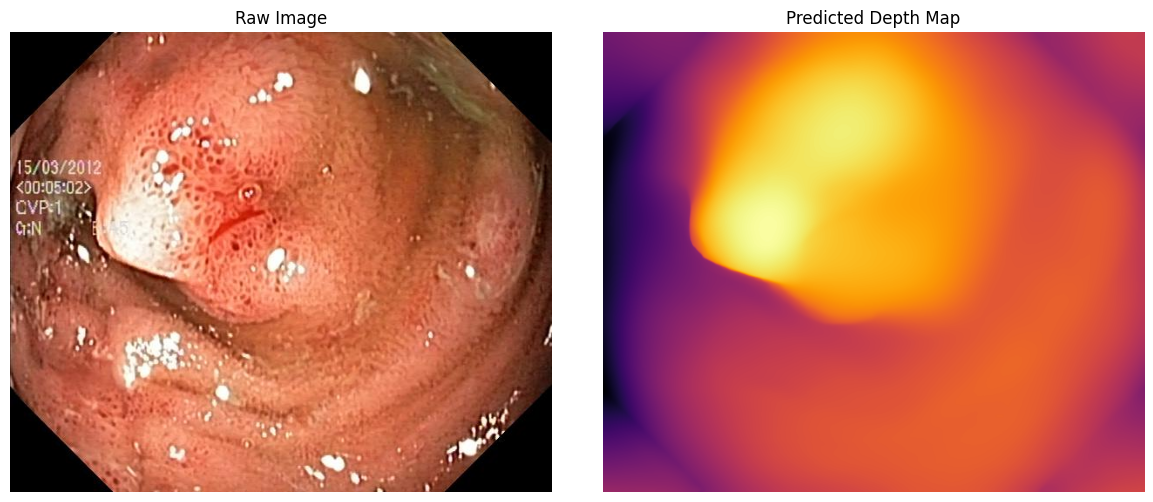

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# BGR(OpenCV) → RGB(matplotlib) 변환
rgb_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

# depth 정규화 (0~1) → 8-bit로 변환
depth_norm = cv2.normalize(depth, None, 0, 255, norm_type=cv2.NORM_MINMAX)
depth_vis = depth_norm.astype(np.uint8)

# 컬러맵 적용해서 보기 좋게
depth_colored = cv2.applyColorMap(depth_vis, cv2.COLORMAP_INFERNO)

# 출력
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Raw Image")
plt.imshow(rgb_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Depth Map")
plt.imshow(depth_colored[..., ::-1])  # BGR to RGB
plt.axis('off')

plt.tight_layout()
plt.show()